Copyright 2022 The Zimtohrli Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Zimtohrli

Zimtohrli is a perceptual audio similarity metric intended to provide a simple scalar value representing the intensity of the human-perceptible difference between two sounds.

It is currently implemented in a Python/JAX version, and an SIMD vectorized C++ version.

The C++ version includes a command line tool to both compute norm-like distance scores based on provided distortions, and visually inspect and compare distortions to originals.

This Colab will present how it works and what the justification of the technical choices are using the Python/JAX implementation of Zimtohrli to display the individual layers it uses to model human hearing.

In [4]:
# @title Import necessary packages

from IPython.display import Markdown, display
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'python'))
import audio_signal
import loudness
import cam
import masking
import zimtohrli


## Filterbank

To model human frequency resolution, the first layer of Zimtohrli implements a filterbank of simple elliptic band pass filters.

The choice of a filterbank instead of an integral transform such as DFT is motivated mainly by filter activation speed and ring duration depending on filter order and bandwidth instead of DFT window size.

This makes each filter in the bank activate as gradually and fast, and ring for as long, as is reasonable for that frequency and bandwith, instead of depending on the window size of an FFT that is likely applied equally for multiple channels.

To demonstrate how this is done, let's begin by constructing an example sound that will show us how the filtering performs.

We will use an exponential chirp, since will be easy to use to demonstrate the response in both the low and high frequency range.

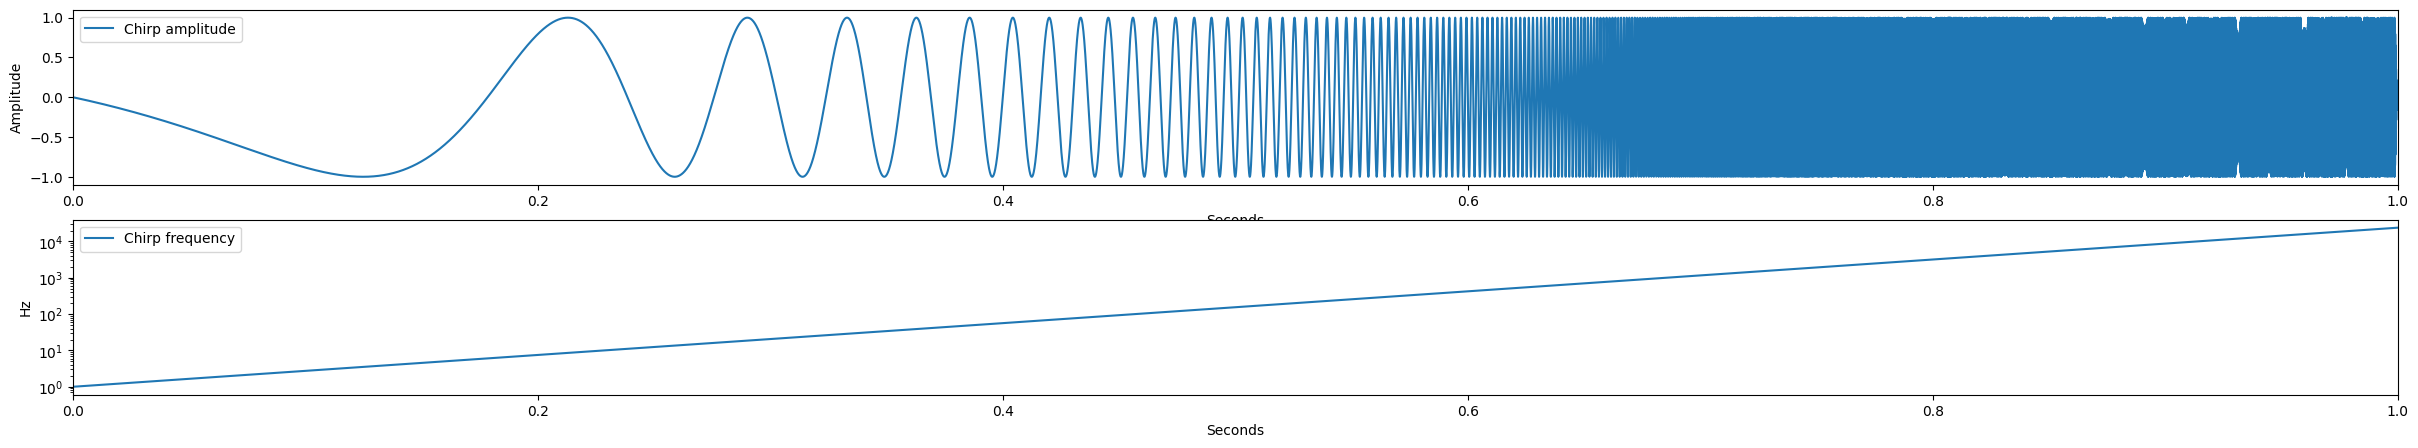

In [5]:
#@title Generate an exponential chirp and plot it's amplitude and frequency over time

sample_rate = 48000.0
chirp_sample_times = jnp.linspace(0.0, 1.0, int(sample_rate))
f0 = 1
f1 = sample_rate / 2
t1 = 1
chirp_freqz = f0 * (f1 / f0) ** (chirp_sample_times / t1)
chirp = audio_signal.Signal(
    sample_rate=sample_rate,
    samples=scipy.signal.chirp(chirp_sample_times, f0, t1, f1, method='logarithmic', phi=90),
)
_, (chirp_ax, chirp_freqz_ax) = plt.subplots(
    2,
    1,
    figsize=(30, 5),
)

chirp_ax.plot(chirp_sample_times, chirp.samples, label='Chirp amplitude')
chirp_ax.set_ylabel('Amplitude')
chirp_ax.set_xlabel('Seconds')
chirp_ax.set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
chirp_ax.legend()

chirp_freqz_ax.plot(chirp_sample_times, chirp_freqz, label='Chirp frequency')
chirp_freqz_ax.set_ylabel('Hz')
chirp_freqz_ax.set_xlabel('Seconds')
chirp_freqz_ax.set_yscale('log')
chirp_freqz_ax.set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
chirp_freqz_ax.legend()

plt.show()

The filter used is a first order elliptic filter, as described by [scipy.signal.ellip](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html), with a passband ripple of 3dB. The stopband ripple parameter doesn't have an effect for first order elliptic filters in the [scipy source](https://github.com/scipy/scipy/blob/v1.11.4/scipy/signal/_filter_design.py#L3335-L3457), and is thus ignored here. This filter isn't very sharp, but reacts quickly.

Creating a bank of these elliptic filters so that they overlap at the 3dB attenuation edges of the passband, with an even width in [ERB](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth), provides a number of channels that should represent perceptually equally wide frequency bands.

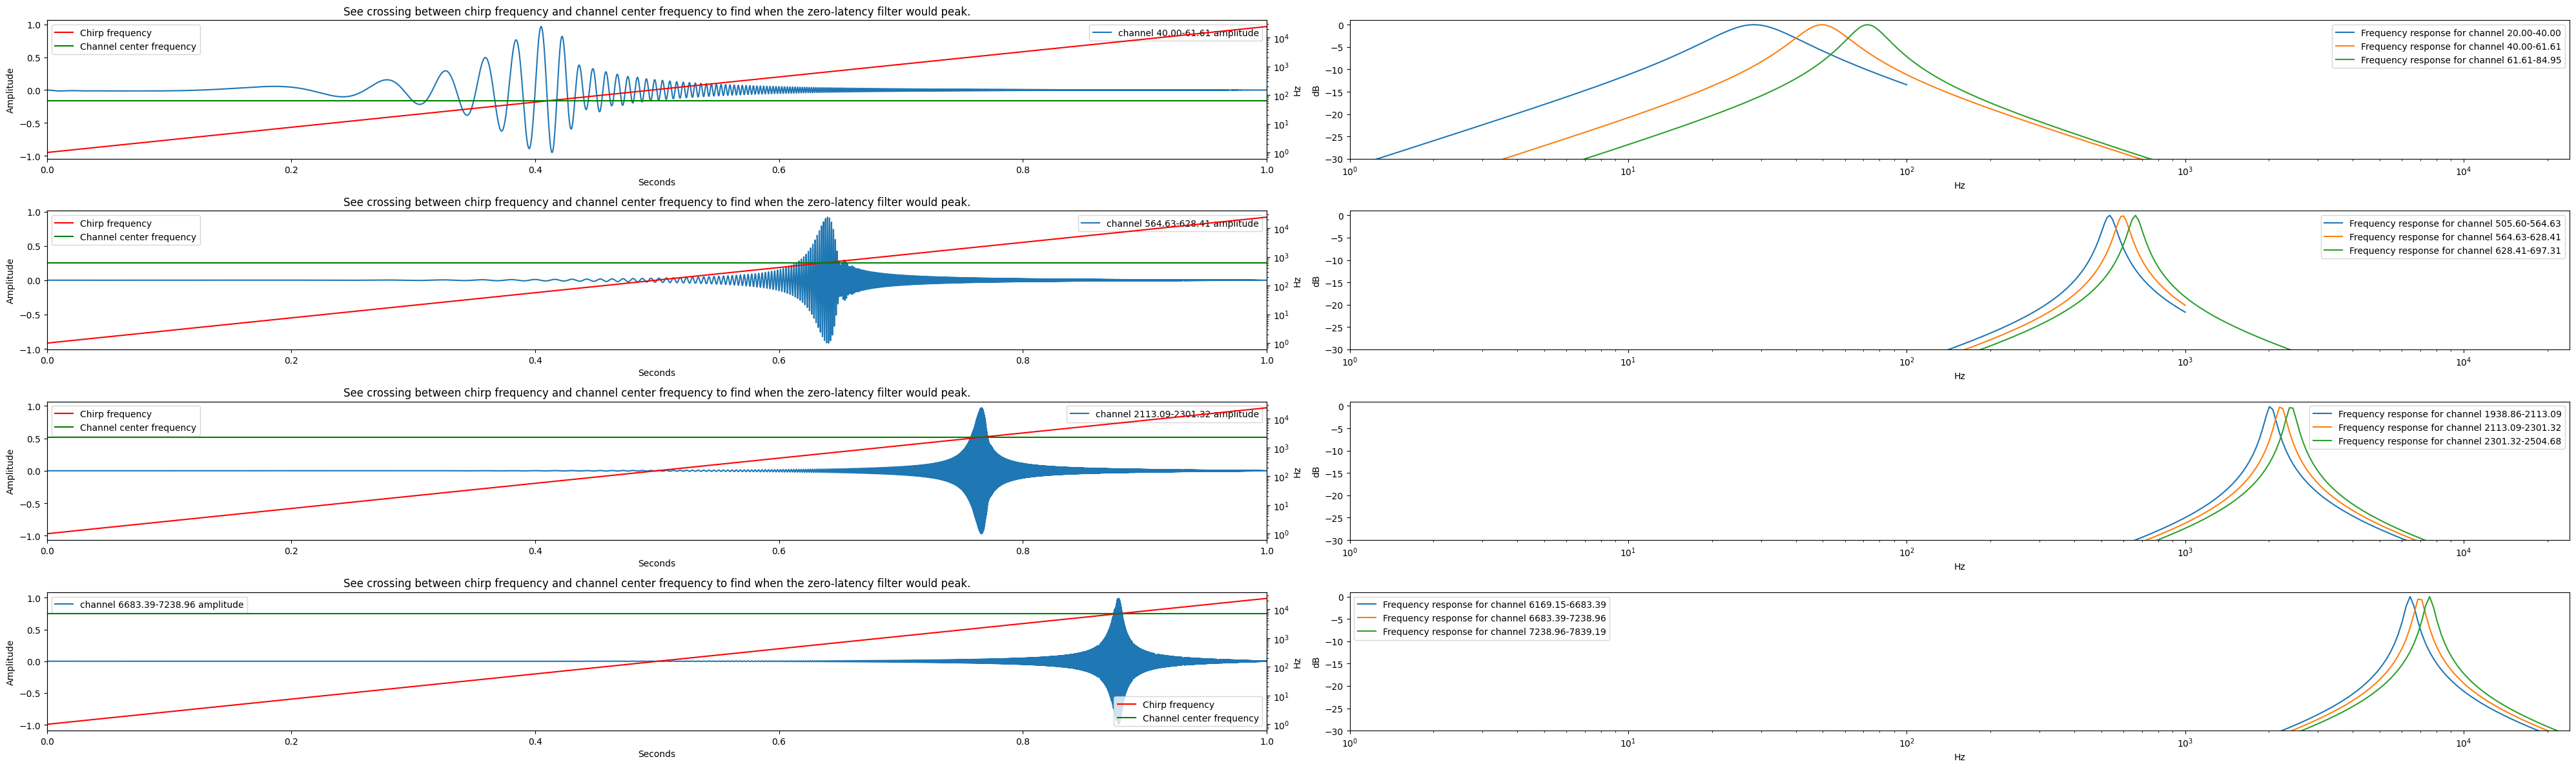

In [6]:
# @title Plot some channels of chirp filtered by bank with 10Hz resolution at narrowest filter
c = cam.Cam(minimum_channel_width_hz=20)
channels = c.channel_filter(chirp)
channels_to_plot = 4
_, ax = plt.subplots(
    channels_to_plot,
    2,
    figsize=(40, 3 * channels_to_plot),
)
channel_step = channels.samples.shape[0] // channels_to_plot
for ax_index in range(channels_to_plot):
  channel_index = ax_index * channel_step + 1
  ax[ax_index][0].plot(
      chirp_sample_times,
      channels.samples[channel_index],
      label=(
          'channel'
          f' {channels.freqs[channel_index, 0]:.2f}-{channels.freqs[channel_index, 1]:.2f} amplitude'
      ),
  )
  ax[ax_index][0].set_ylabel('Amplitude')
  ax[ax_index][0].set_xlabel('Seconds')
  ax[ax_index][0].set_xlim((0, chirp.samples.shape[0] / chirp.sample_rate))
  ax[ax_index][0].legend()
  ax[ax_index][0].set_title('See crossing between chirp frequency and channel center frequency to find when the zero-latency filter would peak.')
  ax2 = ax[ax_index][0].twinx()
  ax2.plot(chirp_sample_times, chirp_freqz, 'r', label='Chirp frequency')
  ax2.plot([jnp.min(chirp_sample_times), jnp.max(chirp_sample_times)], [channels.freqs[channel_index, 1], channels.freqs[channel_index, 1]], 'g', label='Channel center frequency')
  ax2.set_yscale('log')
  ax2.set_ylabel('Hz')
  ax2.legend()

  def plot_filter(channel_index):
    ba = scipy.signal.ellip(
        N=c.elliptic_order,
        rp=c.elliptic_ripple_pass,
        rs=c.elliptic_ripple_stop,
        Wn=(channels.freqs[channel_index, 0], channels.freqs[channel_index, 1]),
        btype='bandpass',
        analog=True,
        output='ba',
        fs=None,
    )
    w, h = scipy.signal.freqs(*ba, worN=500)
    ax[ax_index][1].plot(
        w,
        20 * jnp.log10(jnp.abs(h)),
        label=(
            'Frequency response for channel'
            f' {channels.freqs[channel_index, 0]:.2f}-{channels.freqs[channel_index, 1]:.2f}'
        ),
    )
  plot_filter(channel_index-1)
  plot_filter(channel_index)
  plot_filter(channel_index+1)
  ax[ax_index][1].set_ylabel('dB')
  ax[ax_index][1].set_xlabel('Hz')
  ax[ax_index][1].set_xscale('log')
  ax[ax_index][1].set_xlim((1, sample_rate * 0.5))
  ax[ax_index][1].set_ylim((-30, 1))
  ax[ax_index][1].legend()

plt.tight_layout()
plt.show()

These sample channels are then converted to energy channels by squaring the sample values and summing them over 10ms windows for downsampling to 100Hz, to approximate human temporal resolution of sound events.

## Masking model

After splitting the input signal into 100Hz energy channels Zimtohrli applies a masking model on the channels.

The masking model computes the perceptible energy in each channel loosely based on [Auditory Masking and its Effect on our Perception of Sound](https://blogs.qsc.com/live-sound/auditory-masking-and-its-effect-on-our-perception-of-sound/), [Auditory Time-Frequency Masking: Psychoacoustical Data and Application to Audio Representations](https://www.researchgate.net/figure/Results-of-Experiment-1-amount-of-masking-in-dB-as-a-function-of-F-in-ERB-units_fig1_258259835), [Auditory Time-Frequency Masking for Spectrally and Temporally Maximally-Compact Stimuli](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0166937), and our own experiments.

### Max energy of fully masked probe

The first step of the model is to compute the fully masked energy between each combination of two channels, as masker and probe. To do this, the fully masked energy of a probe a given distance in [ERB](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth) from the masker and masker energy is computed using a piecewise linear approximation.

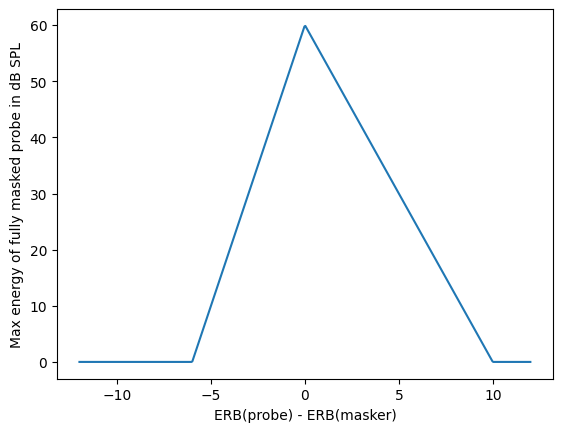

In [7]:
# @title Fully masked energy with 80dB SPL masker
m = masking.Masking()
cam_delta = jnp.linspace(-12, 12, 500)
plt.plot(
    cam_delta,
    m.full_masking(cam_delta, 80),
)
plt.ylabel('Max energy of fully masked probe in dB SPL')
plt.xlabel('ERB(probe) - ERB(masker)')
plt.show()

It then simply calculates the possible masking of all channels by all other channels, and sets all fully masked channels to zero.

Though if it's fairly simple to demonstrate that even not fully masked sounds will be experienced as less intense in the presence of maskers, we have not yet managed to design a model that predicts this successfully.

### Masking model effects

To demonstrate the effects of the different parts of the masking model, we can create a sound consisting of two superpositioned exponential chirps and then plot their matplotlib-spectrogram, Zimtohrli energy spectrogram, and Zimtohrli partial energy spectrogram.

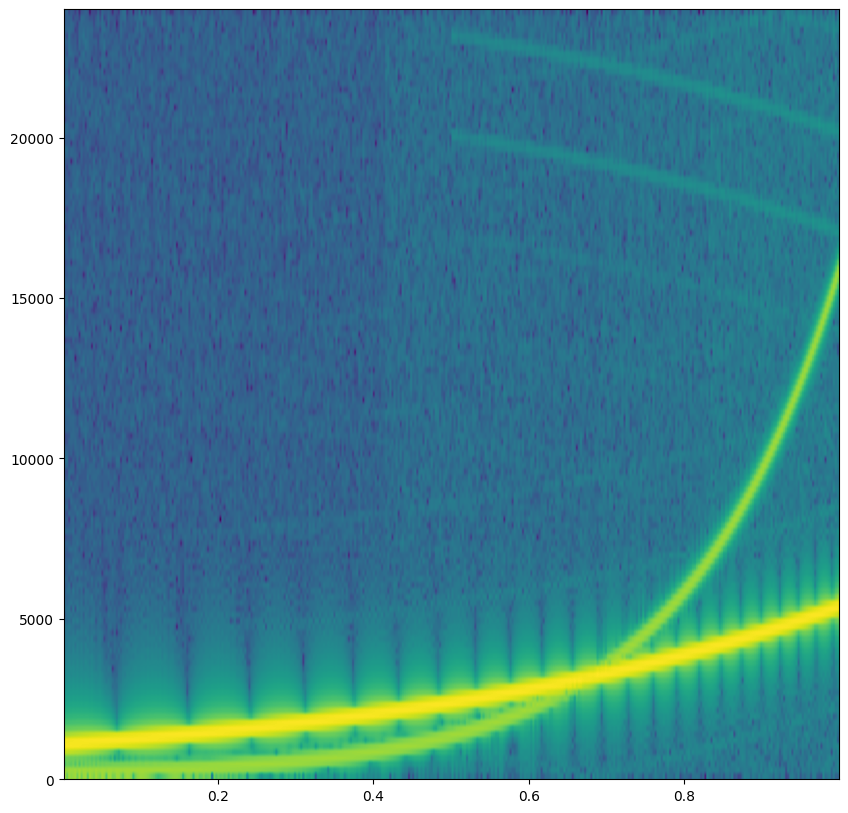

In [8]:
# @title Plot the matplotlib spectrogram

f0_0 = 1000
f1_0 = sample_rate / 9
e_0 = -10
f0_1 = 100
f1_1 = sample_rate / 3
e_1 = -20
two_chirps = audio_signal.Signal(
    sample_rate=sample_rate,
    samples=(
        10 ** (e_0 * 0.1)
        * scipy.signal.chirp(
            chirp_sample_times, f0_0, t1, f1_0, method='logarithmic', phi=90
        )
        + 10 ** (e_1 * 0.1)
        * scipy.signal.chirp(
            chirp_sample_times, f0_1, t1, f1_1, method='logarithmic', phi=90
        )
    ),
)

plt.figure(figsize=(10, 10))
plt.specgram(two_chirps.samples, Fs=sample_rate)
plt.show()


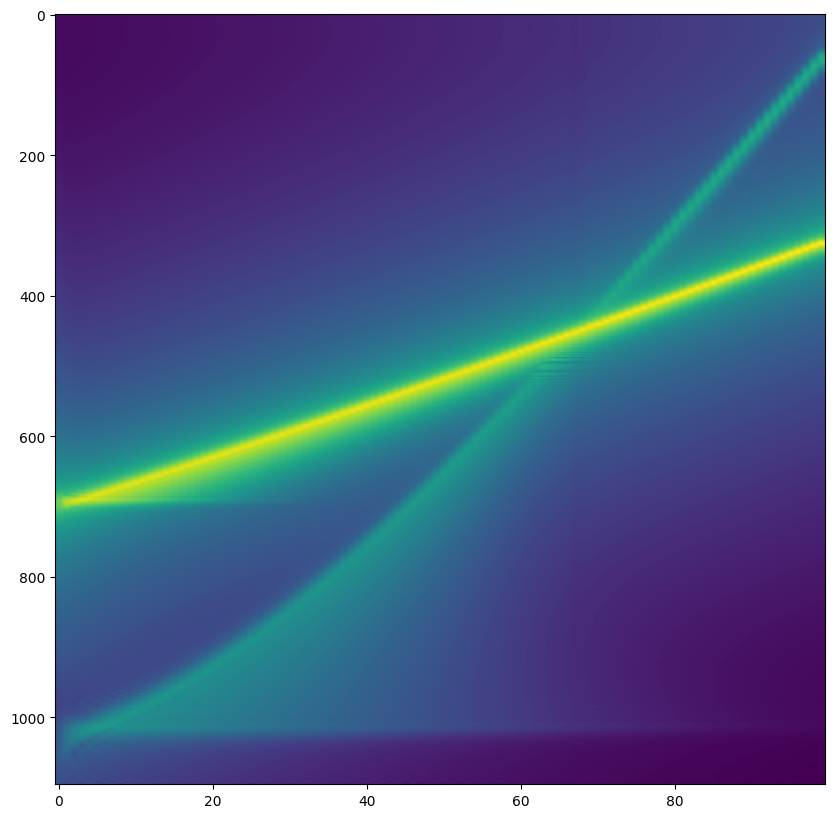

In [9]:
#@title Plot the Zimtohrli energy spectrogram


two_chirp_c = cam.Cam()
two_chirp_channels = two_chirp_c.channel_filter(two_chirps)
energy = two_chirp_channels.energy().to_db()

plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(energy.samples, axis=0), aspect=energy.samples.shape[1] / energy.samples.shape[0])
plt.show()

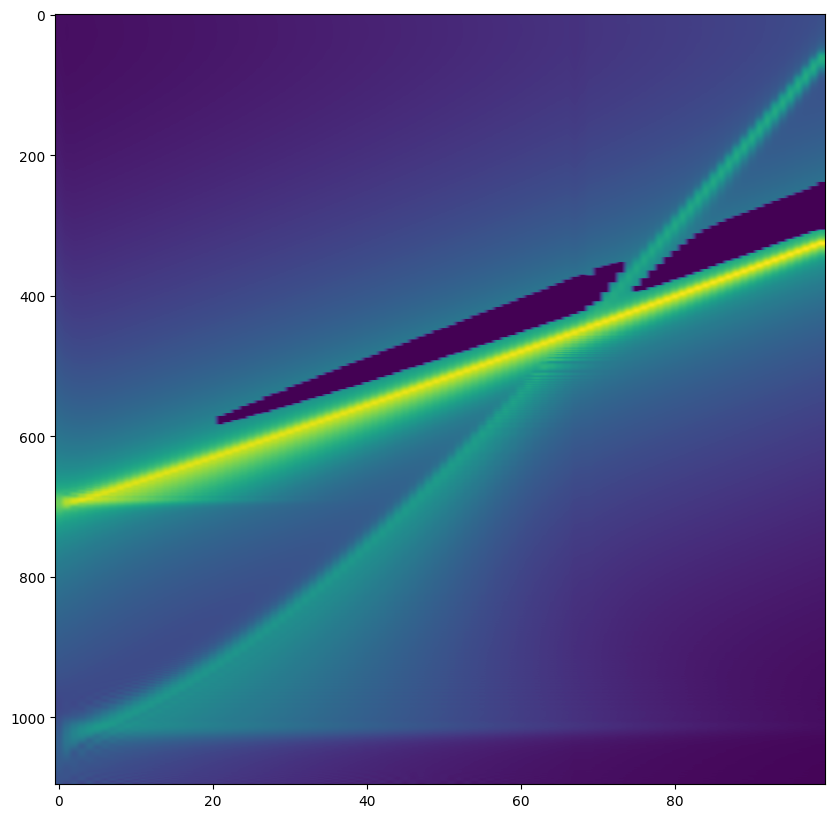

In [10]:
#@title Plot the Zimtohrli partial energy (post masking) spectrogram {display-mode: "form"}


m = masking.Masking()
partial_energy = m.non_masked_energy(energy)
plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(partial_energy.samples, axis=0), aspect=partial_energy.samples.shape[1] / partial_energy.samples.shape[0])
plt.show()

It can be observed how the two chirps mask a certain amount of spectrum around them in the frequency domain, mostly higher frequencies, as well as a certain amount before and after them (due to filter insensitivity and ringing).

Conceptually this matches human hearing masking, in particular simultaneous masking and in a more limited way forward temporal masking.

More tuning of the parameters from listening test training data is expected to improve the match with subjective human hearing.

## Loudness model

After having computed partial dB for all channels in the sound, a loudness model based on ISO 226 (see e.g. https://en.wikipedia.org/wiki/Equal-loudness_contour) is applied to weigh the different spectrums and energy levels according to human sensitivity to sound energy.

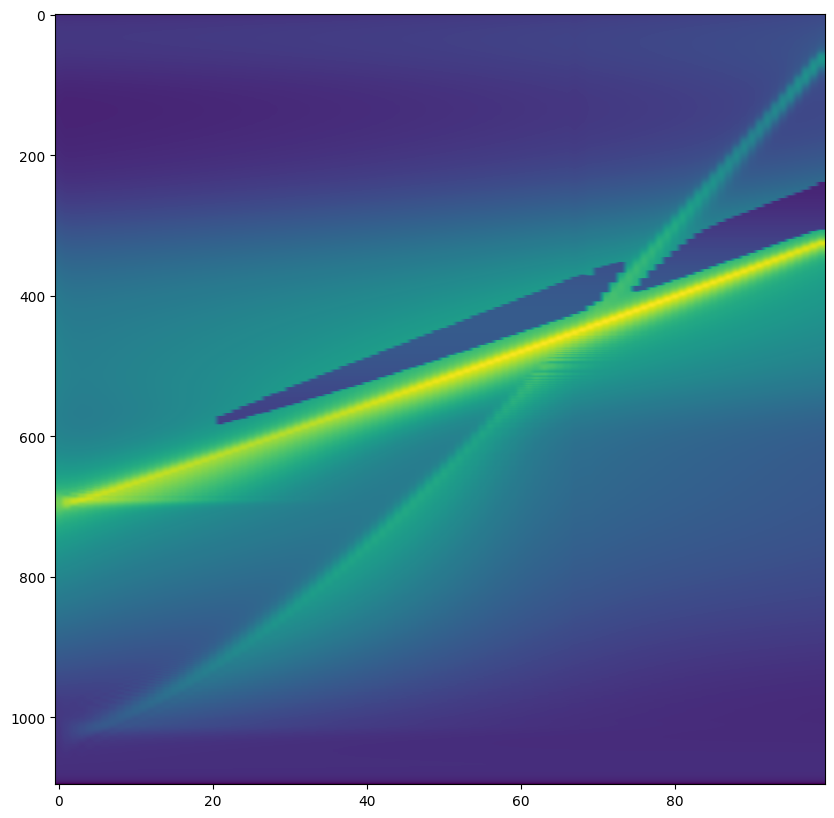

In [11]:
#@title Plot the Zimtohrli loudness (post loudness model) spectrogram {display-mode: "form"}


l = loudness.Loudness()
partial_loudness = l.phons_from_spl_for_channels(partial_energy)
plt.figure(figsize=(10, 10))
plt.imshow(jnp.flip(partial_loudness.samples, axis=0), aspect=partial_loudness.samples.shape[1] / partial_loudness.samples.shape[0])
plt.show()

# Final scoring

The final Zimtohrli distance metric is computed using NSIM (Neural structural similarity metric, https://doi.org/10.1016/j.specom.2011.09.004), which can be viewed as the product of windowed intensity and structural differences between the two sound spectrograms.